# Custom LSTM vs. Attention-based LSTM Models: A Comparative Experiment for Financial Time Series Forecasting

## Inspired by the paper "A Comparison of LSTMs And Attention Mechanisms for Forecasting Financial Time Series" by S.E.Yi, A.Viscardi, and T.Hollis, published in 2018

### The experimental project within the frame of the Research Practice course at the National University of "Kyiv-Mohyla Academy" in summer semester of 2023/2024 academic year

In [1]:
from google.colab import files
uploaded = files.upload()

Saving AMZN.csv to AMZN.csv


In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Layer, Dense, Dropout
import tensorflow.keras.backend as K

### 0. Understand the data nature

In [5]:
amzn_stocks = pd.read_csv('AMZN.csv', index_col='Date')

In [6]:
amzn_stocks.drop(columns=['High', 'Low', 'Adj Close', 'Volume'], inplace=True)

In [7]:
amzn_stocks.head()

,Open,Close
Date,,
1997-05-15,2.437500,1.958333
1997-05-16,1.968750,1.729167
1997-05-19,1.760417,1.708333
1997-05-20,1.729167,1.635417
1997-05-21,1.635417,1.427083


In [8]:
amzn_stocks.dtypes

Open     float64
Close    float64
dtype: object

In [9]:
amzn_stocks.shape

(6257, 2)

In [10]:
amzn_stocks.notna().sum()

Open     6257
Close    6257
dtype: int64

In [11]:
print(f'Timestamp of the earliest stock: {amzn_stocks.index.min()}\n\
Timestamp of the latest stock: {amzn_stocks.index.max()}')

Timestamp of the earliest stock: 1997-05-15
Timestamp of the latest stock: 2022-03-24


### 1. Data Visualization

In [22]:
fig_open = px.line(amzn_stocks['Open'])
fig_close = px.line(amzn_stocks['Close'])

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Open Prices', 'Close Prices'))

for trace in fig_open['data']:
  trace.update(line=dict(color='green'))
  fig.add_trace(trace, row=1, col=1)

for trace in fig_close['data']:
  trace.update(line=dict(color='red'))
  fig.add_trace(trace, row=1, col=2)

fig.update_layout(template='plotly_dark',
                   title={'text': 'Open and Close Prices of Amazon Stocks',
                          'y': 0.9,
                          'x': 0.5,
                          'xanchor': 'center'})

fig.update_xaxes(title_text='Date, years', row=1, col=1)
fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_xaxes(title_text='Date, years', row=1, col=2)
fig.update_yaxes(title_text='Price', row=1, col=2)

fig.write_image('open_and_close.svg')
fig.show()

In [23]:
amzn_stocks['MA20'] = amzn_stocks['Close'].rolling(window=20).mean() # approximately 1 trading month
amzn_stocks['MA100'] = amzn_stocks['Close'].rolling(window=100).mean() # approximately 4-5 trading months
amzn_stocks['MA250'] = amzn_stocks['Close'].rolling(window=250).mean() # approximately 1 trading year


fig = px.line(amzn_stocks,
              y=['MA20', 'MA100', 'MA250'],
              template='plotly_dark')
fig.update_layout(
    title={'text': 'Stock Close Prices with Moving Averages',
           'y': 0.9,
           'x': 0.5,
           'xanchor': 'center'},
    xaxis_title='Dates, years',
    yaxis_title='Price',
    bargap=0,
    bargroupgap=0
)
fig.write_image('moving_avgs.svg')
fig.show()
amzn_stocks.drop(columns=['MA20', 'MA100', 'MA250'], inplace=True)

In [24]:
amzn_stocks['daily_return'] = amzn_stocks['Close'].pct_change()

amzn_stocks = amzn_stocks.iloc[1:]

fig = px.line(amzn_stocks,
              x=amzn_stocks.index,
              y='daily_return',
              labels={'daily_return': 'Daily Return', 'index': 'Date, years'})

fig.update_layout(title={'text': 'Daily Returns of Amazon Stocks',
                         'y': 0.9,
                         'x': 0.5,
                         'xanchor': 'center'},
                  template='plotly_dark',
                  xaxis_title='Date',
                  yaxis_title='Daily Return')
fig.write_image('daily_return.svg')
fig.show()

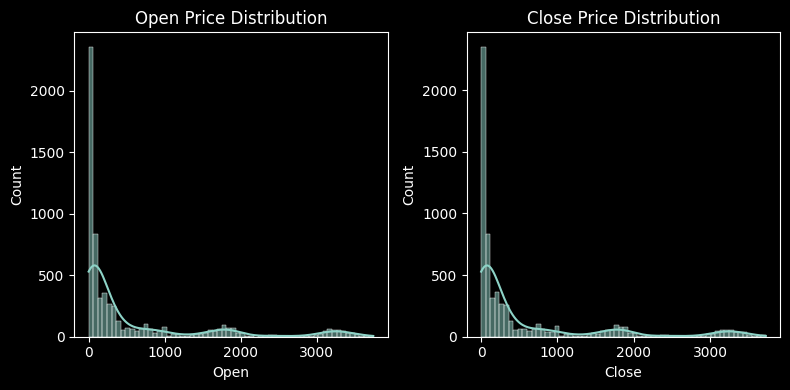

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(amzn_stocks['Open'], ax=ax[0], kde=True)
ax[0].set_title('Open Price Distribution')

sns.histplot(amzn_stocks['Close'], ax=ax[1], kde=True)
ax[1].set_title('Close Price Distribution')
fig.tight_layout()
fig.show()

### 2. Data Cleaning

In [26]:
amzn_stocks.drop(columns=['daily_return'], inplace=True)
cols_to_rename = {
    'Open': 'open',
    'Close': 'close'
}
amzn_stocks.rename(columns=cols_to_rename,
                   inplace=True)

In [27]:
amzn_stocks.head()

,open,close
Date,,
1997-05-16,1.968750,1.729167
1997-05-19,1.760417,1.708333
1997-05-20,1.729167,1.635417
1997-05-21,1.635417,1.427083
1997-05-22,1.437500,1.395833


### 3. Data Preparation

In [28]:
ms = MinMaxScaler()
amzn_stocks[amzn_stocks.columns] = ms.fit_transform(amzn_stocks)

In [29]:
n_splits = 22
tscv = TimeSeriesSplit(n_splits=n_splits)

In [30]:
for train_index, test_index in tscv.split(amzn_stocks):
    train_df, val_df = amzn_stocks.iloc[train_index], amzn_stocks.iloc[test_index]

In [31]:
amzn_stocks.shape

(6256, 2)

In [32]:
train_df.shape, val_df.shape

((5984, 2), (272, 2))

In [33]:
def lag_data(df, lag_param):
    """
    A function which splits the dataset into X and y to enable forecasting.

    Params:
        Args:
            df: dataframe we want to split.
        Kwargs:
            lag_param: the size of the window which defines how many past days'
                       data we are using for next day's stock (default=1).

    Returns: tuple of np.arrays: X (predictors) and  y (target variable).
    """
    X, y = [], []
    i = 0
    for j in range(lag_param, len(df)):
        X.append(df.iloc[i:j])
        y.append(df.iloc[j])
        i += 1
    return np.array(X), np.array(y)

In [34]:
X_train, y_train = lag_data(train_df, lag_param=22)
X_train.shape, y_train.shape

((5962, 22, 2), (5962, 2))

In [35]:
X_val, y_val = lag_data(val_df, lag_param=22)
X_val.shape, y_val.shape

((250, 22, 2), (250, 2))

### 4. Custom Base LSTM Building and Evaluation

In [52]:
tf.random.set_seed(123)

In [53]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu',
                    return_sequences=True,
                    input_shape=(X_train.shape[1],
                                 X_train.shape[2])))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(2))
lstm_model.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=['mean_absolute_error'])

In [54]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 22, 50)            10600     
                                                                 
 dropout_2 (Dropout)         (None, 22, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
lstm_history = lstm_model.fit(X_train, y_train,
                              epochs=80,
                              validation_data=(X_val, y_val),
                              verbose=1)

Epoch 1/80
187/187 [==============================] - 7s 24ms/step - loss: 0.0034 - mean_absolute_error: 0.0213 - val_loss: 0.0017 - val_mean_absolute_error: 0.0336
Epoch 2/80
187/187 [==============================] - 4s 23ms/step - loss: 2.1562e-04 - mean_absolute_error: 0.0083 - val_loss: 0.0023 - val_mean_absolute_error: 0.0387
Epoch 3/80
187/187 [==============================] - 7s 35ms/step - loss: 1.8489e-04 - mean_absolute_error: 0.0073 - val_loss: 0.0021 - val_mean_absolute_error: 0.0377
Epoch 4/80
187/187 [==============================] - 4s 22ms/step - loss: 1.6938e-04 - mean_absolute_error: 0.0073 - val_loss: 0.0015 - val_mean_absolute_error: 0.0312
Epoch 5/80
187/187 [==============================] - 4s 22ms/step - loss: 2.1206e-04 - mean_absolute_error: 0.0080 - val_loss: 0.0027 - val_mean_absolute_error: 0.0433
Epoch 6/80
187/187 [==============================] - 5s 29ms/step - loss: 1.4983e-04 - mean_absolute_error: 0.0065 - val_loss: 0.0013 - val_mean_absolute_erro

In [56]:
def plot_loss(model_history, metric: str, title: str):
  """
  A function which plots the loss curve of a given model for a specified metric.

  Params:
    model_history(tensorflow.python.keras.callbacks.History): object returned
by .fit() method that stores information on the model's performance for each epoch.
    metric: metric we are interested in its demonstrating.
    title: final plot name.
  """
  plt.plot(model_history.history[metric])
  plt.plot(model_history.history[f'val_{metric}'])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel(metric.capitalize())
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

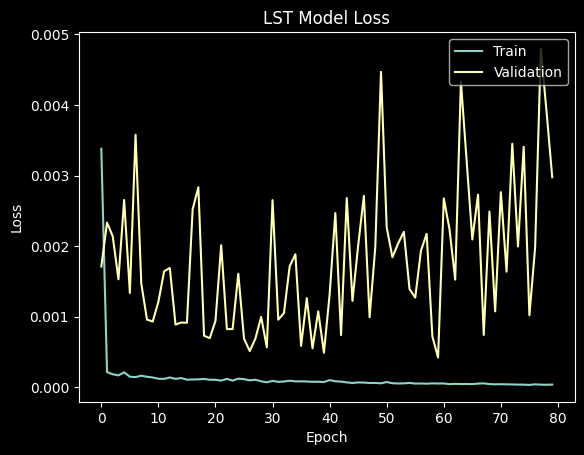

In [57]:
plot_loss(lstm_history, 'loss', 'LST Model Loss')

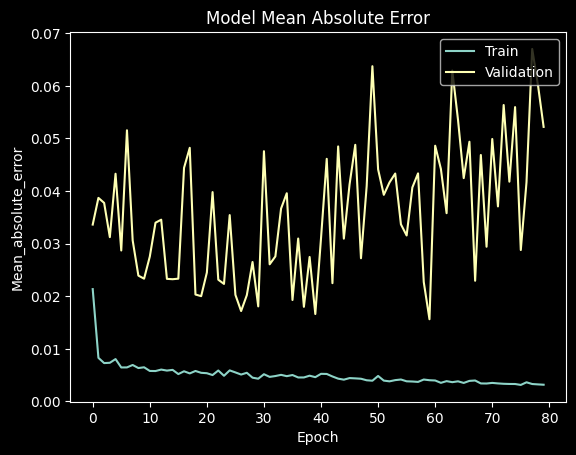

In [58]:
plot_loss(lstm_history, 'mean_absolute_error', 'Model Mean Absolute Error')

In [59]:
train_min_loss = min(lstm_history.history['loss'])
val_min_loss = min(lstm_history.history['val_loss'])

### 5. Attention-based LSTM Building and Evaluation

In [44]:
class Attention(Layer):
  """
  A custom Keras layer implementing the Attention mechanism.
  Attributes:
    W(tensorflow.Variable): weight matrix for Attention calculation.
    b(tensorflow.Variable): bias vector for Attention calculation.

  Methods:
    __init__(self, **kwargs):
      Initializes the object Attention(Layer) type.

    build(self, input_shape):
      Builds the layer by defining the shape of weights based on the
input shape.
    call(self, vector_x):
      Performs the forward pass of the layer.
  """
  def __init__(self, **kwargs):
    super(Attention, self).__init__(**kwargs)

  def build(self, input_shape):
    self.W = self.add_weight(name='attention_weight',
                             shape=(input_shape[-1], 1),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(name='attention_bias',
                             shape=(input_shape[1], 1),
                             initializer='zeros',
                             trainable=True)

    super(Attention, self).build(input_shape)

  def call(self, vector_x):
    e = K.tanh(K.dot(vector_x, self.W)+self.b)
    e = K.squeeze(e, axis=-1)
    alpha = K.softmax(e)
    alpha = K.expand_dims(alpha, axis=-1)
    context_vector = vector_x * alpha
    context_vector = K.sum(context_vector, axis=1)
    return context_vector

In [45]:
input_shape = (X_train.shape[1], X_train.shape[-1]) # (time_steps, features_number) -> (22, 2)
inputs = Input(shape=input_shape)
lstm_output_1 = LSTM(128, return_sequences=True)(inputs)
dropout = Dropout(0.1)(lstm_output_1)
lstm_output_2 = LSTM(128, return_sequences=True)(dropout)
attention_output = Attention()(lstm_output_2)
dense_output = Dense(64, activation='relu')(attention_output)
outputs = Dense(1)(dense_output)

attention_model = Model(inputs=inputs, outputs=outputs)
attention_model.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])

In [46]:
attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22, 2)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 22, 128)           67072     
                                                                 
 dropout_1 (Dropout)         (None, 22, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 22, 128)           131584    
                                                                 
 attention (Attention)       (None, 128)               150       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65    

In [47]:
att_history = attention_model.fit(X_train, y_train,
                                  epochs=40,
                                  validation_data=(X_val, y_val),
                                  verbose=1)

Epoch 1/40
187/187 [==============================] - 21s 90ms/step - loss: 0.0010 - mean_absolute_error: 0.0127 - val_loss: 0.0043 - val_mean_absolute_error: 0.0516
Epoch 2/40
187/187 [==============================] - 16s 85ms/step - loss: 2.2303e-04 - mean_absolute_error: 0.0078 - val_loss: 0.0022 - val_mean_absolute_error: 0.0391
Epoch 3/40
187/187 [==============================] - 16s 84ms/step - loss: 2.5728e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0023 - val_mean_absolute_error: 0.0395
Epoch 4/40
187/187 [==============================] - 16s 86ms/step - loss: 1.9688e-04 - mean_absolute_error: 0.0070 - val_loss: 0.0021 - val_mean_absolute_error: 0.0380
Epoch 5/40
187/187 [==============================] - 15s 80ms/step - loss: 2.1573e-04 - mean_absolute_error: 0.0076 - val_loss: 0.0026 - val_mean_absolute_error: 0.0420
Epoch 6/40
187/187 [==============================] - 15s 78ms/step - loss: 2.0400e-04 - mean_absolute_error: 0.0074 - val_loss: 0.0020 - val_mean_absolut

In [48]:
att_train_min_loss = min(att_history.history['loss'])
att_val_min_loss = min(att_history.history['val_loss'])

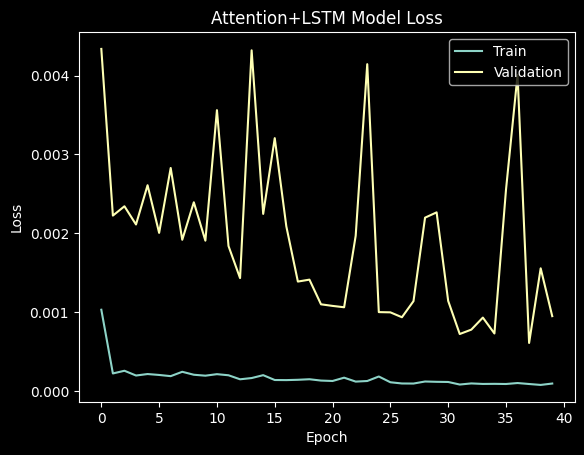

In [49]:
plot_loss(att_history, 'loss', 'Attention+LSTM Model Loss')

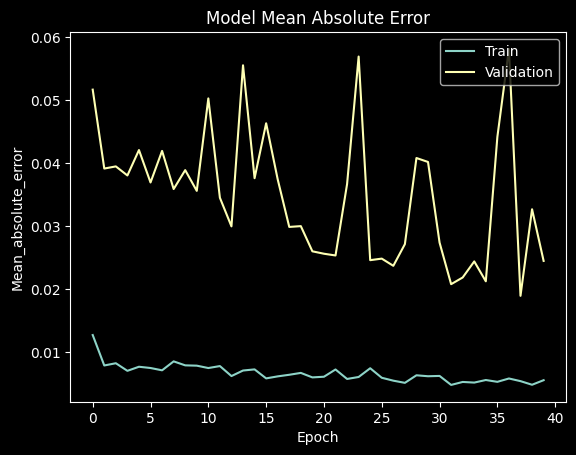

In [50]:
plot_loss(att_history, 'mean_absolute_error', 'Model Mean Absolute Error')

### 6. Models' Metrics Comparison

In [51]:
error_vals = []
error_labels = ['lstm train loss', 'attention train loss', 'lstm validation loss', 'attention validation loss']
error_vals.extend([train_min_loss, att_train_min_loss, val_min_loss, att_val_min_loss])
series_error_vals = pd.DataFrame([error_vals], columns=error_labels)
transposed_series_error_vals = series_error_vals.T
transposed_series_error_vals.columns = ['loss_value']
transposed_series_error_vals

,loss_value
lstm train loss,0.000032
attention train loss,0.000078
lstm validation loss,0.000355
attention validation loss,0.000610


Based on this experimental implementation, we have obtained the following results: